In [152]:
import pandas as pd
import numpy as np
import datetime
from filegenerators import *
from typing import Dict, List, Union, Optional
pd.options.display.float_format = '{:.2e}'.format
from pathlib import Path
import subprocess
from CovCor_calc import OptimaMechtest, OptimaOutput, OptimaSensitivity
import seaborn as sns
import os
import copy
from scipy.linalg import sqrtm, logm
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

In [2]:
class Theoretical_Ranges:
    def __init__(self, range_file: str, sheet_name: str, input_names: list[str],
                 must_be_zero: list[str]) -> None:
        
        self.df_species_ics = pd.read_excel(range_file, sheet_name=sheet_name)
        self.df_species_ics['value'] = self.df_species_ics['value'].astype(float)
        self.must_be_zero = must_be_zero
        self.get_input_data(input_names)
        self.gen_lookuptable()

    def get_input_data(self, input_names: list[str]) -> None:
        self.inputs = {}
        for i in input_names:
            self.inputs[i] = 0.0
        self.inputs["REF"] = 1.0
        self.inputs["Insulin"] = 1e-10

        self.input_data = pd.DataFrame([
            {'species': species, 'minconc': value, 'value': value, 'maxconc': value}
            for species, value in self.inputs.items()])

    def gen_lookuptable(self) -> None:
        self.lut = pd.concat([self.df_species_ics, self.input_data], ignore_index=True)    # look-up-table
        self.lut['species'] = self.lut['species'].str.upper()
        print(f"LUT was created successfully. Its dimensions are: {self.lut.shape}")

    def makeBounds(self, old = True):
        bounds = dict()
        for index, row in self.df_species_ics.iterrows():
            if row.value < 0.1:
                lb = 1e-14
                ub = 1e-13
            elif old:
                lb = (row.value/2)*1e-12
                ub = (row.value*1.5)*1e-12
            else:
                lb = (row.minconc)*1e-12
                ub = (row.maxconc)*1e-12
            bounds[row.species] = [lb, ub]
        return bounds

In [3]:
class Basal:
    def __init__(self, rng: Theoretical_Ranges, sampling_type: str, wide = False) -> None:
        self.rng = rng
        self.wide = wide
        self.old = self.get_sampling_type(sampling_type)   # Should be 'old' or 'new'
        self.bounds = self.rng.makeBounds(self.old)
        self.get_observables()
        self.rel_sigmas = self.get_sigma_dict()
        self.get_dataPoints()

    def get_sampling_type(self, sampling_type: str) -> bool:
        if sampling_type == 'old':
            if self.wide == True:
                raise ValueError("If the sampling type is 'old', wide needs to be False.")
            else:
                self.sampling_type = 'old'
                return True
        elif sampling_type == 'new':
            if self.wide:
                self.sampling_type = 'wide_new'
            else:
                self.sampling_type = 'new'
            return False
        else:
            raise ValueError("The sampling type can either be 'old' or 'new'.")

    def __str__(self) -> str:
        kiir = f"Fields:\ndim(bounds): {len(self.bounds)}\n" + \
               f"dim(observables): {len(self.observables)}\n" + \
               f"dim(sigma_dict): {len(self.rel_sigmas)}\n" + \
               f"dim(dataPoints): {self.dataPoints.shape}"
        return kiir

    def get_observables(self) -> None:
        self.observables = []
        for index, row in self.rng.df_species_ics.iterrows():
            if row.value > 0:
                self.observables.append(row.species)

    def get_sigma_dict(self) -> dict[str, float]:
        rel_sigmas = dict()

        for index, row in self.rng.df_species_ics.iterrows():
            if row.species in self.rng.inputs.keys():
                # if row.species not in observables:
                continue
            if row.value in self.rng.must_be_zero and row.species not in self.rng.inputs.keys():
                rel_sigmas[row.species] = 5e-14
            elif row.species not in self.rng.inputs.keys() and row.species in self.observables:
                if self.wide and row.minconc != row.maxconc:
                    rel_sigmas[row.species] = ((row.maxconc-row.minconc)/8)*1e-12
                else:
                    rel_sigmas[row.species] = ((row.value*1.5-row.value/2)/8)*1e-12
        return rel_sigmas

    def get_dataPoints(self) -> None:
        columns = list(set(self.observables)-set(self.rng.inputs.keys()))
        columns.sort()
        columns.insert(0,'time')
        time = np.linspace(0,24,25)

        self.dataPoints = pd.DataFrame(columns=columns)
        self.dataPoints['time'] = time*60

        # Fill in the "theoretical" stationary conentrations
        for index, row in self.rng.df_species_ics.iterrows():
            if row.species in self.dataPoints.columns:
                if row.value == 0:
                    self.dataPoints.loc[:,row.species] = 1e-13
                else:
                    self.dataPoints.loc[:,row.species] = row.value*1e-12

In [4]:
class Genesis:  # As in it creates the xmls ~ the cells {= life ;)} with different initial conditions
    def __init__(self, basal: Basal, num_of_xmls: int, make_dirs = True,
                 output_directory: str = '/home/nvme/Opt/7_Krisztian/xml/') -> None:
        self.basal = basal
        self.num_xmls = num_of_xmls
        self.maxdigit = len(str(num_of_xmls))
        self.check_output_dir(output_directory, make_dirs=make_dirs)

    def check_output_dir(self, output_directory, make_dirs) -> None:
        if self.basal.old and not self.basal.wide:
            folder_name = f"Basal_{self.num_xmls}_old"
        elif not self.basal.old and not self.basal.wide:
            folder_name = f"Basal_{self.num_xmls}_new"
        else:
            folder_name = f"Basal_{self.num_xmls}_wide_new"

        self.output_dir = os.path.join(output_directory, folder_name)

        if not os.path.exists(self.output_dir) and make_dirs:
            os.makedirs(self.output_dir)
            print(f"No existing directory was found at {self.output_dir}. Creating one now...")

    def let_there_be_life(self) -> None:
        species = self.basal.rng.df_species_ics.species.to_list()
        inputs = self.basal.rng.inputs
        input_names = inputs.keys()
        only_vars = list(set(species)-set(input_names))

        for i in range(1, self.num_xmls+1):
            file_index = i
            generate_file(file_index, self.output_dir, only_vars, inputs,
                          self.basal.bounds, self.basal.dataPoints,
                          self.basal.rel_sigmas, self.maxdigit)

        print("job finished")

In [5]:
class Simulation:
    def __init__(self, gen: Genesis, xmls_in_one_opp: int, opp_output_dir: str,
                 opp_name_prefix: str, all_in_one=False, kiir=True) -> None:
        self.gen = gen
        self.all_in_one = all_in_one
        self.get_xml_vec(xmls_in_one_opp)
        self.opp(opp_output_dir, opp_name_prefix, kiir)

    def get_xml_vec(self, xmls_in_one_opp) -> None:
        if self.all_in_one:
          self.xmls = np.arange(1, self.gen.num_xmls + 1, 1)
        else:
          self.xmls = []
          for i in range(1, self.gen.num_xmls, xmls_in_one_opp):
            xml_cnt = np.arange(i, i+xmls_in_one_opp, 1) 
            self.xmls.append(xml_cnt)

    def opp(self, opp_output_dir, opp_name_prefix, kiir) -> None:
        self.opps = []
        self.indices = []
        if self.all_in_one:
          opp_filename = f"{opp_name_prefix}_BCRN_corr_{self.xmls[-1]}_{self.gen.basal.sampling_type}.opp"
          self.opps.append(opp_filename)
          self.indices.append(f"{self.xmls[-1]}")
          if kiir:
            opp_content = self.generate_opp_content(self.gen.output_dir, name='stac', num_xmls=self.xmls)
            with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
              f.write(opp_content)
        else:
          for num in self.xmls:
              opp_filename = f"{opp_name_prefix}_BCRN_corr_{num[-1]}_{self.gen.basal.sampling_type}.opp"
              self.opps.append(opp_filename)
              self.indices.append(f"{num[-1]}")
              if kiir:
                opp_content = self.generate_opp_content(self.gen.output_dir, name='stac', num_xmls=num)
                with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
                  f.write(opp_content)

    def generate_opp_content(self, xml_folder: str, num_xmls: Union[list[int], list[list[int]]], mech_file: str = "7_Krisztian/mech/BCRN6.inp", 
                            name: str = 'stac', yaml_file: str = "7_Krisztian/mech/BCRN6.yaml", time_limit: int = 50, thread_limit: int = 32,
                            settings_tag: str = "systems_biology", solver: str = "cantera", extension: str = ".xml") -> str:

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         BCRN6
      MECH_FILE        {mech_file}
      COMPILE_cantera  {yaml_file}
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  BCRN6
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml in num_xmls:
          padded_number = str(xml).zfill(self.gen.maxdigit)
          mechtest += f"      NAME {xml_folder}/{name}_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def sim_runner(self, log_location:str = ''):
      self.parent_path = parent_path = Path.cwd().parents[1]
        
      if log_location == '':
        for idx, opp_file in enumerate(self.opps):
            command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
            print(f"Running: {' '.join(command)}")
            subprocess.run(command, check=True, cwd=parent_path)
      else:
        for idx, opp_file in enumerate(self.opps):
          command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
          print(f"Running: {' '.join(command)}")
          if self.all_in_one:
             log_idx = self.xmls[-1]
          else:
             log_idx = self.xmls[idx][-1]
          with open(f"../logs/2025526/run_log_old{log_idx}.txt", "w") as log:
              subprocess.run(command, check=True, stdout=log, stderr=subprocess.STDOUT, cwd=parent_path)


In [6]:
class Natural_Selection:
    def __init__(self, sim: Simulation) -> None:
        self.sim = sim
        self.sim_data: dict[str, OptimaMechtest] = {}
        self.get_sim_data()
        self.survival_of_the_fittest()

    def get_sim_data(self) -> None:
        for idx, key in enumerate(self.sim.indices):
            self.sim_data[key] = OptimaMechtest(self.sim.opps[idx])

    def sigma_range(self, meas, sim, sigma):
        radius = (sim-meas)/sigma
        return radius
    
    def isit_init(self, row, wide=False):
        lut = self.sim.gen.basal.rng.lut
        rel_sigmas = self.sim.gen.basal.rel_sigmas
        for k, v in row.items():
            right_row = lut[lut['species'] == k]

            if right_row.empty or k not in rel_sigmas.keys():
                #print(f"Species '{species}' not found in lut — skipping.")
                continue    # ezekre: BEC1A, PI3K, PI3KA, SERCAA nincsen adat a ranges tablazatban

            meas = right_row['value'].iloc[0] * 1e-12

            if not wide:
                radius = self.sigma_range(meas=meas, sim=v*1e-12, sigma=rel_sigmas[k])
            else:
                radius = self.sigma_range(meas=meas, sim=v*1e-12, sigma=rel_sigmas[k])

            if radius >= 4:
                return False

        return True
    
    def survival_of_the_fittest(self) -> None:
        self.good_xmls = []
        for idx in self.sim.indices:
            for xml_name, row in self.sim_data[idx].df_followed34.iterrows():
                all_ok = self.isit_init(row)
                if all_ok:
                    self.good_xmls.append(xml_name)
        print(f"Found {len(self.good_xmls)} good xmls")

    def filtering(self) -> None:
        data = copy.deepcopy(self.sim_data)
        first = True
        self.filtered_basal = pd.DataFrame()
        self.filtered_followed = pd.DataFrame()
        for k, v in data.items():
            v.df_basal.index = v.df_basal.index.str[7:-9]
            v.df_basal = v.df_basal.sort_index()
            if first:
                self.filtered_basal = v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]
                self.filtered_followed = v.df_followed34[[xml in self.good_xmls for xml in v.df_followed34.index]]
                first = False
            else:
                self.filtered_basal = pd.concat([self.filtered_basal, v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]],
                                        ignore_index=False)
                self.filtered_followed = pd.concat([self.filtered_followed, v.df_followed34[[xml in self.good_xmls for xml in v.df_followed34.index]]],
                                            ignore_index=False)

    def get_cov_cor(self, corr_xmls, keys: list[str]) -> None:
        self.dict_b = {}
        self.dict_f = {}
        self.dict_b_corr = {}
        self.dict_f_corr = {}
        self.dict_b_cov = {}
        self.dict_f_cov = {}
        for idx, range in enumerate(corr_xmls):
            self.dict_f[f"{keys[idx]}"] = self.filtered_followed.iloc[range].copy()
            self.dict_b[f"{keys[idx]}"] = self.filtered_basal.iloc[range].copy()
            self.dict_b_corr[f"{keys[idx]}"] = self.filtered_basal.iloc[range].copy().corr()
            self.dict_f_corr[f"{keys[idx]}"] = self.filtered_followed.iloc[range].copy().corr()
            self.dict_f_cov[f"{keys[idx]}"] = self.filtered_followed.iloc[range].copy().cov()
            self.dict_b_cov[f"{keys[idx]}"] = self.filtered_basal.iloc[range].copy().cov()


In [87]:
def kl_mvn(m0, S0, m1, S1):
    """
    https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv
    The following function computes the KL-Divergence between any two 
    multivariate normal distributions 
    (no need for the covariance matrices to be diagonal)
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    - accepts stacks of means, but only one S0 and S1
    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    # 'diagonal' is [1, 2, 3, 4]
    tf.diag(diagonal) ==> [[1, 0, 0, 0]
                          [0, 2, 0, 0]
                          [0, 0, 3, 0]
                          [0, 0, 0, 4]]
    # See wikipedia on KL divergence special case.              
    #KL = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)   
                if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))                               
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N)

def kl_divergence_gaussians(mu0, cov0, mu1, cov1):
    """
    KL divergence D_KL(N0 || N1) between two multivariate Gaussians N0 ~ (mu0, cov0) and N1 ~ (mu1, cov1)
    """
    k = mu0.shape[0]
    cov1_inv = np.linalg.inv(cov1)
    diff = mu1 - mu0

    term1 = np.log(np.linalg.det(cov1) / np.linalg.det(cov0))
    term2 = np.trace(cov1_inv @ cov0)
    term3 = diff.T @ cov1_inv @ diff

    return 0.5 * (term1 - k + term2 + term3)

def plot_corr_matrix(df_corr, title="", figsize=(12, 10), vmin=-1, vmax=1, fontsize=7, dropNa = False, save_fig=False):
    
    if dropNa:
        df_corr = df_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

    fig1 = plt.figure(figsize=figsize)
    sns.heatmap(df_corr, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                vmin=vmin,
                vmax=vmax,
                xticklabels=True,
                yticklabels=True,
                square=True,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    fig1.patch.set_facecolor('#f8f6f6')
    if save_fig:
        plt.savefig(f"pics/{title}.pdf")
    plt.show()

In [9]:
def correlation_matrix_distance(A, B):
    """Correlation Matrix Distance (CMD), Herdin et al. (2005), https://doi.org/10.1049/el:20057319"""
    numerator = np.trace(A @ B)
    denominator = np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')
    return 1 - (numerator / denominator)

def rv_coefficient(A, B):
    """RV Coefficient, Escoufier (1973), https://doi.org/10.1016/0378-3758(78)90121-8"""
    numerator = np.trace(A @ B)
    denominator = np.sqrt(np.trace(A @ A) * np.trace(B @ B))
    return numerator / denominator

def safe_airm(A, B, epsilon=1e+1):
    """If COV() matrix is singular, https://doi.org/10.1016/S0047-259X(03)00096-4"""
    A_spd = A + epsilon * np.eye(A.shape[0])
    B_spd = B + epsilon * np.eye(B.shape[0])
    A_inv_sqrt = np.linalg.inv(sqrtm(A_spd))
    log_term = logm(A_inv_sqrt @ B_spd @ A_inv_sqrt)
    return np.linalg.norm(log_term, 'fro')

def affine_invariant_riemannian(A, B):
    """Affine-Invariant Riemannian Distance, https://doi.org/10.1007/s11263-005-3222-z"""
    try:
        A_inv_sqrt = np.linalg.inv(sqrtm(A))
        log_term = logm(A_inv_sqrt @ B @ A_inv_sqrt)
        return np.linalg.norm(log_term, 'fro')
    except:
        print("Matrix is singular, switching to linear shrinkage estimator formula")
        safe_airm(A, B)

def bures_wasserstein_distance(A, B):
    """Bures–Wasserstein Distance, https://doi.org/10.1016/0047-259X(82)90077-X"""
    sqrtA = sqrtm(A)
    middle = sqrtm(sqrtA @ B @ sqrtA)
    return np.sqrt(np.trace(A + B - 2 * middle))

def root_stein_divergence(A, B):
    """Root Stein Divergence, Sra, A New Metric on the Manifold of Kernel Matrices with Application to Matrix Geometric Means, NIPS, 2012"""
    sqrt_product = sqrtm(A @ B)
    return np.trace(A + B - 2 * sqrt_product)

In [10]:
def compute_matrix_distance(mat1, mat2, method='fro', mu1=None, mu2=None):
    if method == 'frobenius':
        return np.linalg.norm(mat1 - mat2, ord='fro')
    elif method == 'cmd':
        return correlation_matrix_distance(mat1, mat2)
    elif method == 'rv':
        return rv_coefficient(mat1, mat2)
    elif method == 'airm':
        return affine_invariant_riemannian(mat1, mat2)
    elif method == 'bures':
        return bures_wasserstein_distance(mat1, mat2)
    elif method == 'rsd':
        return root_stein_divergence(mat1, mat2)
    elif method == 'kl':
        return kl_mvn(mu1, mat1, mu2, mat2)
    else:
        raise ValueError("Unknown method. Use 'frobenius', 'cmd', 'rv', 'airm', 'skl', 'bures', or 'rsd'.")

In [113]:
def plot_correlation_distance_heatmap(dict, corr_xmls, title: str, method='frobenius',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)].values
            mat2 = dict[str(n2)].values
            if method == 'kl':
                mu1 = nat_select.dict_f[str(n1)].mean()
                mu2 = nat_select.dict_f[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

def plot_it(distance_matrix, corr_xmls1, corr_xmls2, method, save_fig, title):
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix,
                xticklabels=corr_xmls1,
                yticklabels=corr_xmls2,
                annot=True,
                cmap='coolwarm',
                square=True,
                cbar_kws={'label': f'{method.upper()} Distance'})
    plt.title(title)
    plt.xlabel('Number of XMLs - Original')
    plt.ylabel('Number of XMLs - New')
    plt.tight_layout()
    fig.patch.set_facecolor('#f8f6f6')
    if save_fig:
        plt.savefig(f"pics/{title}.pdf")
        plt.savefig(f"pics/{title}.png")
    plt.show()

def plot_correlation_matrix_triangle(corr_matrix: np.ndarray, labels=None, title="", 
                                     figsize=(12, 10), cmap='coolwarm', fmt=".2f", 
                                     show_diag=True, save_path=None):
    """
    Plot a lower triangular heatmap of a correlation matrix with annotations.
    """

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0 if not show_diag else 1)

    # Setup the plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                fmt=fmt,
                cmap=cmap,
                vmin=-1, vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.85, 'label': 'Correlation'},
                xticklabels=labels,
                yticklabels=labels,
                ax=ax)

    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(labels, rotation=0, fontsize=9)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


In [12]:
if __name__ == '__main__':
    input_names = ['nS', 'RAP', 'TG', 'dS', 'CCH', 'REF', 'Insulin', 'TG_SERCA', 'mTOR_RAP', 'casp', 'IP3R', 'Baxa', 'tBid']
    must_be_zero = ['casp', 'Baxa', 'tBid', 'p53a', 'PUMA']
    
    rng = Theoretical_Ranges('input_files/reactions_ics_finalised.xlsx', 'icranges',
                               input_names, must_be_zero)
    basal_old = Basal(rng, 'old')
    gen_old = Genesis(basal_old, 15000, make_dirs=False)
    sim_old = Simulation(gen_old, 1000, '../1_mechtest', '2025526', kiir=False)
    nat_select_old = Natural_Selection(sim_old)

LUT was created successfully. Its dimensions are: (84, 4)
Found 14209 good xmls


In [101]:
1835/15000

0.12233333333333334

In [13]:
basal_new = Basal(rng, 'new')
gen_new = Genesis(basal_new, 15000, make_dirs=False)
sim_new = Simulation(gen_new, 1000, '../1_mechtest', '2025526', kiir=False)
nat_select_new = Natural_Selection(sim_new)

Found 91 good xmls


In [16]:
basal_new_wide = Basal(rng, 'new', True)
gen_new_wide = Genesis(basal_new_wide, 15000, make_dirs=False)
sim_new_wide = Simulation(gen_new_wide, 1000, '../1_mechtest', '2025526', kiir=False)
nat_select_new_wide = Natural_Selection(sim_new_wide)

Found 1835 good xmls


In [167]:
nat_select_old.filtering()
nat_select_new_wide.filtering()

In [144]:
corr_xmls_old = [np.arange(0, 50, 1), np.arange(50, 150, 1), np.arange(150, 300, 1), np.arange(300, 500, 1),
                 np.arange(500, 900, 1), np.arange(900, 1835, 1)]
keys_old = ['50', '100', '150', '200', '400', f"{1835 - 900}"]

corr_xmls_new_wide = [np.arange(0, 50, 1), np.arange(50, 150, 1), np.arange(150, 300, 1), np.arange(300, 500, 1),
                 np.arange(500, 900, 1), np.arange(900, len(nat_select_new_wide.good_xmls), 1)]
keys_new_wide = ['50', '100', '150', '200', '400', f"{len(nat_select_new_wide.good_xmls) - 900}"]

nat_select_old.get_cov_cor(corr_xmls_old, keys_old)
nat_select_new_wide.get_cov_cor(corr_xmls_new_wide, keys_new_wide)

In [168]:
corr_xmls_old = [np.arange(0, 50, 1), np.arange(50, 300, 1), np.arange(300, 1000, 1), np.arange(1000, 2500, 1),
                 np.arange(2500, 7000, 1), np.arange(7000, len(nat_select_old.good_xmls), 1)]
keys_old = ['50', '250', '700', '1500', '4500', f"{len(nat_select_old.good_xmls) - 7000}"]

corr_xmls_new_wide = [np.arange(0, 50, 1), np.arange(50, 150, 1), np.arange(150, 300, 1), np.arange(300, 500, 1),
                 np.arange(500, 900, 1), np.arange(900, len(nat_select_new_wide.good_xmls), 1)]
keys_new_wide = ['50', '100', '150', '200', '400', f"{len(nat_select_new_wide.good_xmls) - 900}"]

nat_select_old.get_cov_cor(corr_xmls_old, keys_old)
nat_select_new_wide.get_cov_cor(corr_xmls_new_wide, keys_new_wide)

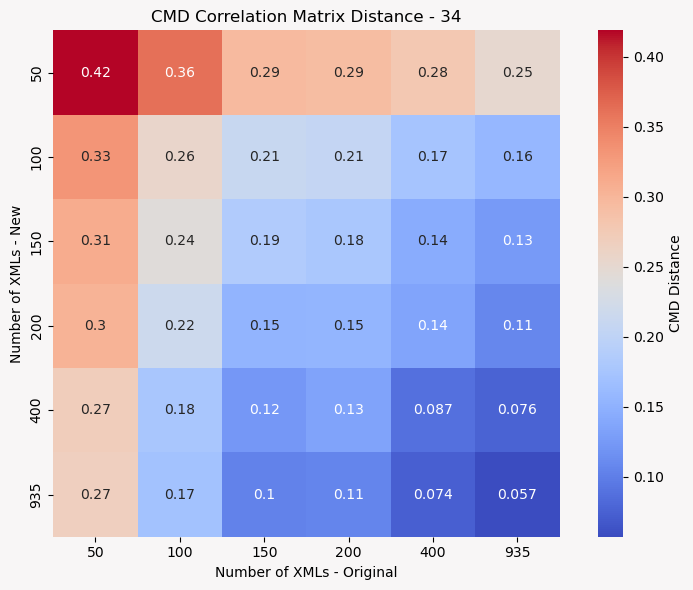

In [149]:
distance_matrix = np.zeros((len(keys_old), len(keys_old)))

for idx1, keys1 in enumerate(keys_old):
    for idx2, keys2 in enumerate(keys_new_wide):
        distance_matrix[idx1, idx2] = compute_matrix_distance(np.nan_to_num(nat_select_old.dict_f_corr[keys1]),
                                                              np.nan_to_num(nat_select_new_wide.dict_f_corr[keys2]), 'cmd')
plot_it(distance_matrix, keys_old, keys_new_wide, 'cmd', True, 'CMD Correlation Matrix Distance - 34')

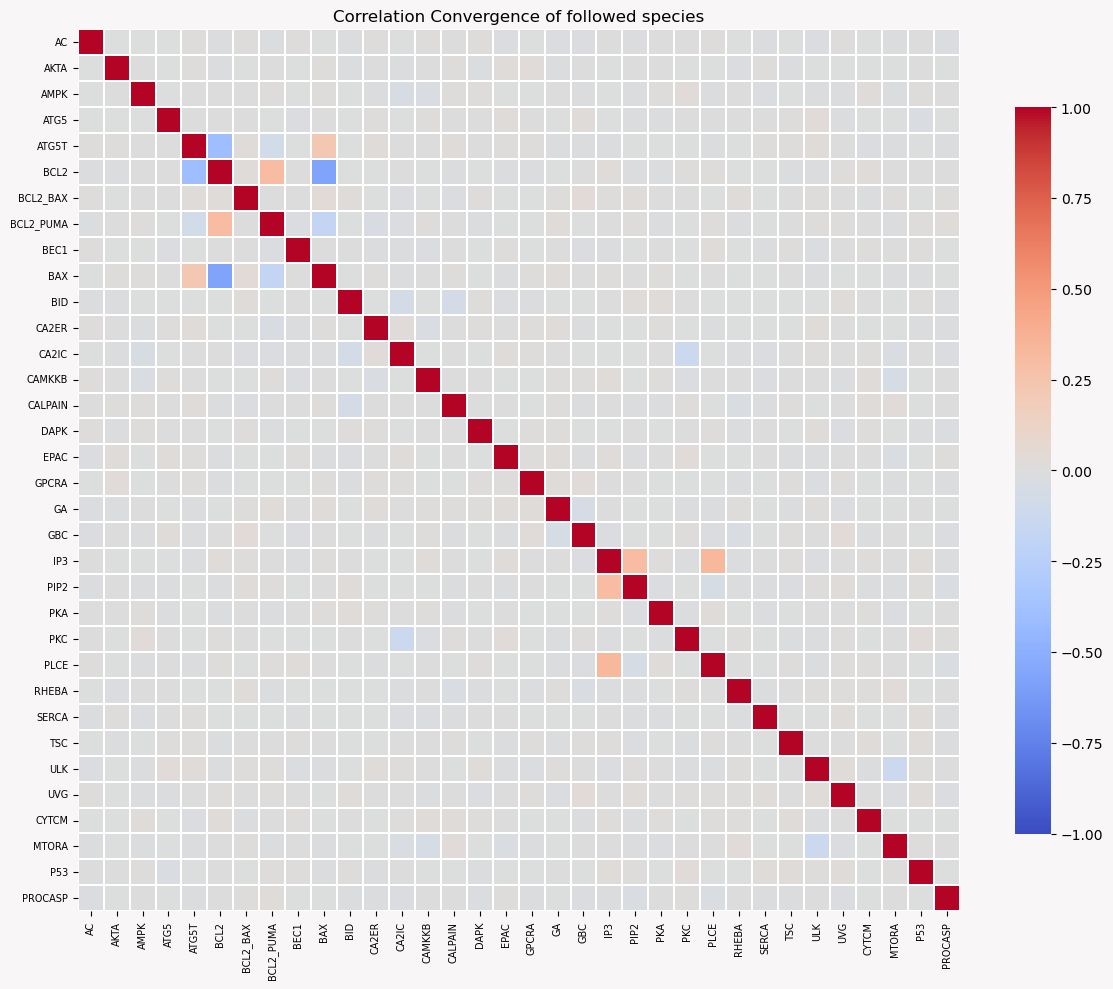

In [91]:
plot_corr_matrix(nat_select_old.dict_f_corr['7209'], 'Correlation Convergence of followed species')

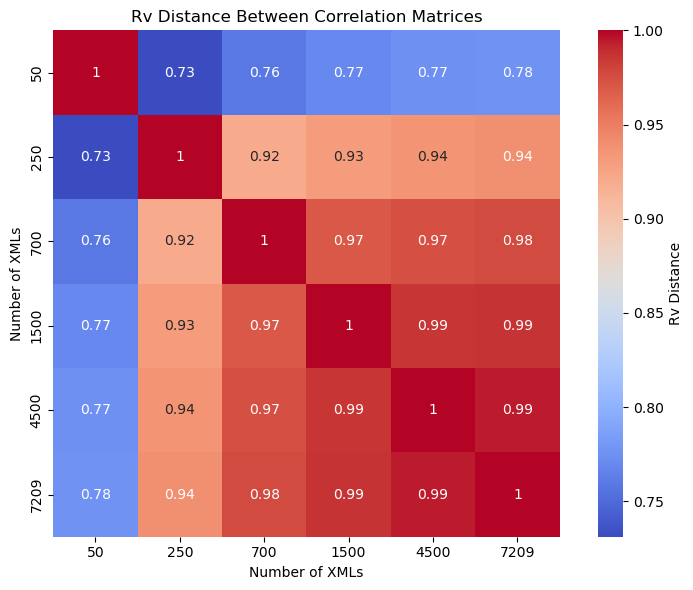

In [43]:
plot_correlation_distance_heatmap(nat_select_old.dict_f_corr, keys_old, method='rv')

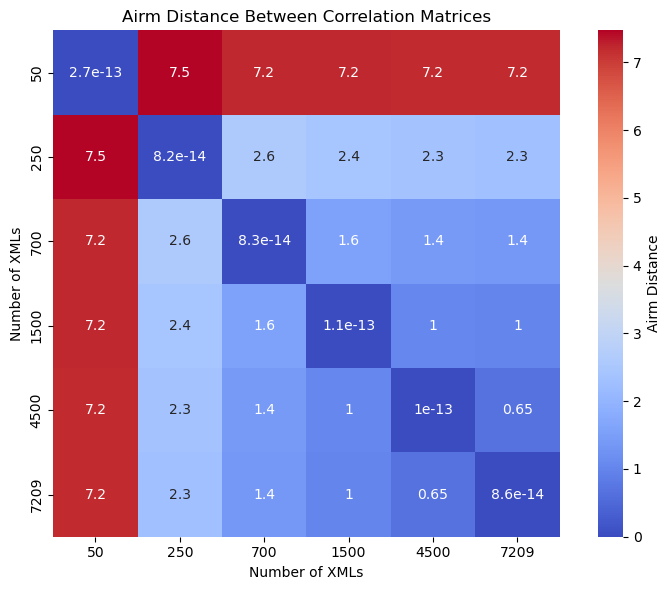

In [61]:
plot_correlation_distance_heatmap(nat_select_old.dict_f_cov, keys_old, method='airm')

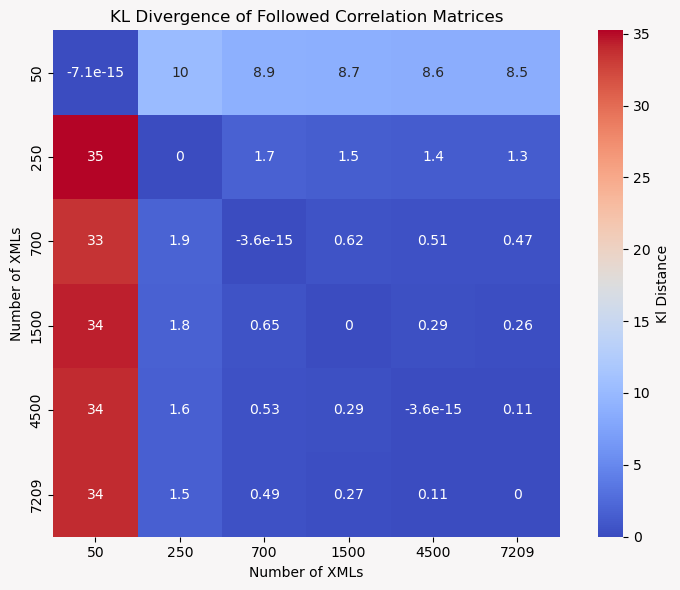

In [97]:
plot_correlation_distance_heatmap(nat_select_old.dict_f_cov, keys_old, method='kl', nat_select=nat_select_old,
                                  title='KL Divergence of Followed Correlation Matrices')

In [169]:
from sklearn.covariance import empirical_covariance, ledoit_wolf

dict_old_leodian = {}
f_dict_old_leodian = {}
shrinkage = {}
f_shrinkage = {}

for k in keys_old:
    dict_old_leodian[k], shrinkage[k] = ledoit_wolf(nat_select_old.dict_b[k])
    f_dict_old_leodian[k], f_shrinkage[k] = ledoit_wolf(nat_select_old.dict_f[k])

In [170]:
shrinkage

{'50': 0.03186768749554223,
 '250': 0.00936550006460849,
 '700': 0.0031992994588450896,
 '1500': 0.0015778189460672737,
 '4500': 0.000500221530954502,
 '7209': 0.0003152255910560402}

In [134]:
def plot_correlation_distance_heatmap_leodit(dict, corr_xmls, title: str, method='frobenius',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method == 'kl':
                mu1 = nat_select.dict_b[str(n1)].mean()
                mu2 = nat_select.dict_b[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

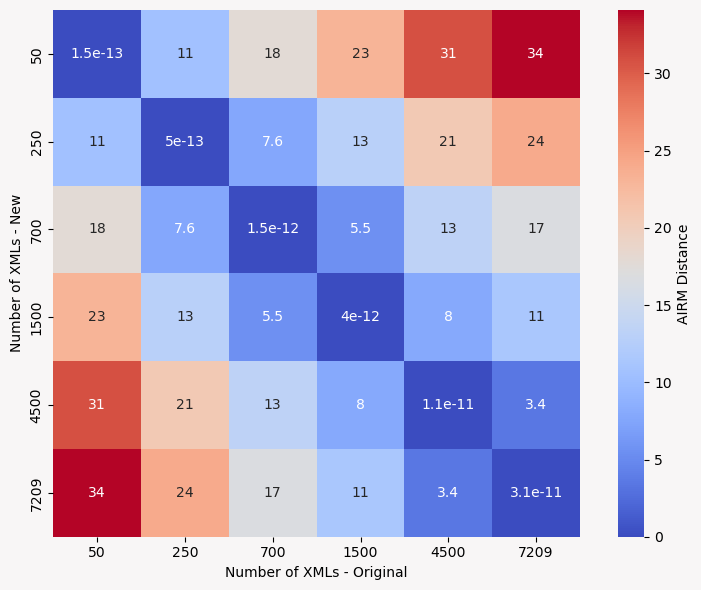

In [132]:
plot_correlation_distance_heatmap_leodit(dict_old_leodian, keys_old, title='', method='airm')

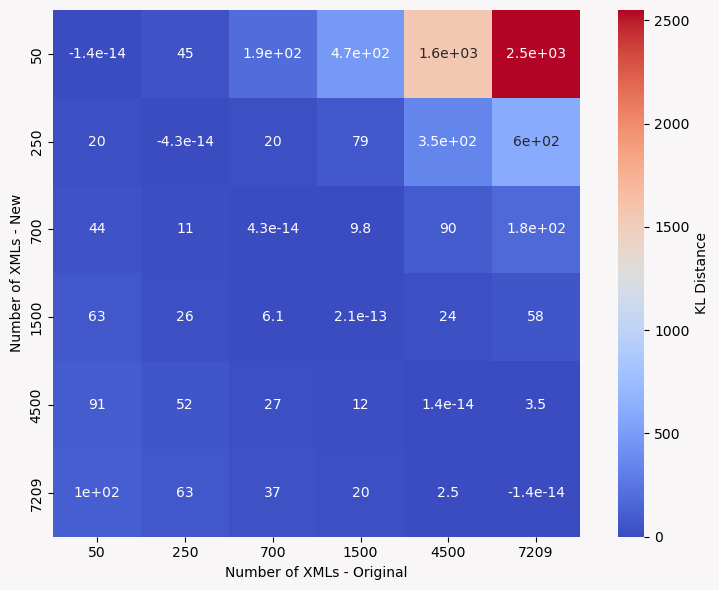

In [137]:
plot_correlation_distance_heatmap_leodit(dict_old_leodian, keys_old, title='', method='kl', nat_select=nat_select_old)

In [196]:
def plot_dual_metric_heatmap(dict, keys,
                              method_lower='cmd', method_upper='frobenius',
                              title='Dual Distance Plot',
                              cmap_lower='Blues', cmap_upper='Reds',
                              save_fig=False,
                              nat_select: Natural_Selection = None):
    n = len(keys)
    data_lower = np.zeros((n, n))
    data_upper = np.zeros((n, n))

    # Compute both metrics for all pairs
    for i, n1 in enumerate(keys):
        for j, n2 in enumerate(keys):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method_lower == 'kl' or method_upper == 'kl':
                mu1 = nat_select.dict_b[str(n1)].mean()
                mu2 = nat_select.dict_b[str(n2)].mean()
            if i >= j:
                data_lower[i, j] = compute_matrix_distance(mat1, mat2, method_lower, mu1=mu1, mu2=mu2)
            elif i < j:
                data_upper[i, j] = compute_matrix_distance(mat1, mat2, method_upper, mu1=mu1, mu2=mu2)

    # Create masks
    mask_lower = np.triu(np.ones_like(data_lower, dtype=bool), k=1)
    mask_upper = np.tril(np.ones_like(data_upper, dtype=bool), k=0)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot lower triangle
    norm_lower = Normalize(vmin=np.min(data_lower[np.tril_indices(n, -1)]),
                           vmax=np.max(data_lower[np.tril_indices(n, -1)]))
    sns.heatmap(data_lower,
                mask=mask_lower,
                cmap=cmap_lower,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax)

    # Plot upper triangle
    norm_upper = Normalize(vmin=np.min(data_upper[np.triu_indices(n, 1)]),
                           vmax=np.max(data_upper[np.triu_indices(n, 1)]))
    sns.heatmap(data_upper,
                mask=mask_upper,
                cmap=cmap_upper,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=keys,
                yticklabels=keys,
                ax=ax)

    ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(keys, rotation=0, fontsize=9)
    ax.set_title(title, fontsize=14, pad=12)

    # Add both colorbars
    cbar_ax1 = fig.add_axes([0.84, 0.25, 0.02, 0.5])  # Right colorbar
    sm1 = cm.ScalarMappable(cmap=cmap_upper, norm=norm_upper)
    sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
    cbar1.set_label(f'{method_upper.upper()} (upper)', rotation=270, labelpad=15)

    cbar_ax2 = fig.add_axes([0.0, 0.25, 0.02, 0.5])  # Left colorbar
    sm2 = cm.ScalarMappable(cmap=cmap_lower, norm=norm_lower)
    sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
    cbar2.set_label(f'{method_lower.upper()} (lower)', rotation=90, labelpad=15)

    #fig.patch.set_facecolor('#f8f6f6')
    plt.tight_layout(rect=[0.1, 0, 0.9, 1])

    if save_fig:
        plt.savefig(f"pics/{title.replace(' ', '_')}.png", dpi=300)
        plt.savefig(f"pics/{title.replace(' ', '_')}.pdf")

    plt.show()

/tmp/ipykernel_632988/3534792979.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0, 0.9, 1])


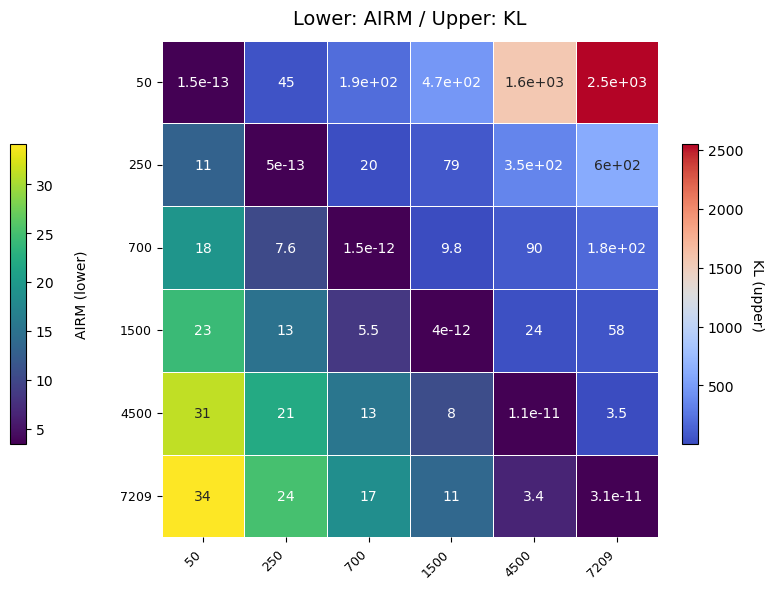

In [197]:
plot_dual_metric_heatmap(dict=dict_old_leodian,
                         keys=keys_old,
                         method_lower='airm',
                         method_upper='kl',
                         title='Lower: AIRM / Upper: KL',
                         cmap_lower='viridis',
                         cmap_upper='coolwarm',
                         save_fig=False,
                         nat_select=nat_select_old)

In [141]:
covar_basal = ledoit_wolf(nat_select_old.filtered_basal)[0]
mv_normal = stats.multivariate_normal(mean=nat_select_old.filtered_basal.mean(), cov=covar_basal, allow_singular=True)
mv_normal.cov, covar_basal

(array([[ 3.36451140e+03,  1.53030881e-02,  7.23417564e-04, ...,
         -6.23233945e+00, -2.52534482e+00,  3.28657401e+00],
        [ 1.53030881e-02,  5.69447739e-01,  4.57697305e-09, ...,
         -3.34023062e-05, -1.30501365e-04, -3.26427951e-03],
        [ 7.23417564e-04,  4.57697305e-09,  5.68778500e-01, ...,
          3.22724237e-06, -3.17756295e-07,  6.61309831e-06],
        ...,
        [-6.23233945e+00, -3.34023062e-05,  3.22724237e-06, ...,
          3.16322281e+02,  3.93142873e+01, -3.95793292e+00],
        [-2.52534482e+00, -1.30501365e-04, -3.17756295e-07, ...,
          3.93142873e+01,  1.24931937e+01, -2.29387702e+00],
        [ 3.28657401e+00, -3.26427951e-03,  6.61309831e-06, ...,
         -3.95793292e+00, -2.29387702e+00,  8.12222473e+02]]),
 array([[ 3.36451140e+03,  1.53030881e-02,  7.23417564e-04, ...,
         -6.23233945e+00, -2.52534482e+00,  3.28657401e+00],
        [ 1.53030881e-02,  5.69447739e-01,  4.57697305e-09, ...,
         -3.34023062e-05, -1.30501365e